# Nosiy channel Model Implementation for Neural Machine Translation

# Implementation Based on Research Paper

## Title:
**Simple and Effective Noisy Channel Modeling for Neural Machine Translation**

## Paper Link:
[Facebook Research Paper (PDF)](https://research.facebook.com/file/4410959105628640/Simple-and-Effective-Noisy-Channel-Modeling-for-Neural-Machine-Translation.pdf)

## Summary:
This implementation is based on the research paper titled *"Simple and Effective Noisy Channel Modeling for Neural Machine Translation"* by Facebook AI Research. The paper proposes a framework that enhances neural machine translation by leveraging a noisy channel model, improving performance especially in low-resource settings.

## Key Concepts:
- **Noisy Channel Framework:** Reformulates translation as maximizing the probability of the source sentence given the target sentence.
- **Channel Model:** Predicts the source sentence from the target sentence.
- **Language Model:** Captures fluency of the target sentence.
- **Decoder:** Uses beam search to integrate both channel and language model scores.

## Modules in Implementation:
1. **Direct Model (`p(y|x)`):** Sequence-to-sequence model trained normally (e.g., Transformer).
2. **Channel Model (`p(x|y)`):** Reverse translation model trained on target-to-source pairs.
3. **Language Model (`p(y)`):** Trained independently on target language corpora.
4. **Beam Search Decoder:** Combines scores from all three models to generate final translations.

## Goal of Implementation:
To build and evaluate a neural machine translation system enhanced with the noisy channel model, demonstrating improvements in translation quality, particularly in scenarios with limited parallel data.

## 1. Imports

In [ ]:
!pip install streamlit torch transformers sacrebleu pandas matplotlib seaborn

In [53]:
import torch
import pandas as pd
import re
import csv
import time
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from sacrebleu import corpus_bleu, sentence_bleu
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Loading Pre-trained models

In [34]:
# 1. Load Your Models

def load_models():
    """Load all required models for translation"""
    # Direct model: English --> Hindi
    print("Loading direct model...")
    direct_model_name = "Helsinki-NLP/opus-mt-en-hi"
    direct_tokenizer = AutoTokenizer.from_pretrained(direct_model_name)
    direct_model = AutoModelForSeq2SeqLM.from_pretrained(direct_model_name).to(device)
    direct_model.eval()

    # Channel model: Hindi --> English
    print("Loading channel model...")
    channel_model_name = "snehalyelmati/mt5-hindi-to-english"
    channel_tokenizer = AutoTokenizer.from_pretrained(channel_model_name)
    channel_model = AutoModelForSeq2SeqLM.from_pretrained(channel_model_name).to(device)
    channel_model.eval()

    # Language model for Hindi
    print("Loading Hindi language model...")
    lm_model_name = "ai4bharat/IndicBART"
    lm_tokenizer = AutoTokenizer.from_pretrained(lm_model_name)
    lm_model = AutoModelForCausalLM.from_pretrained(lm_model_name).to(device)
    lm_model.eval()
    
    return {
        'direct_model': direct_model,
        'direct_tokenizer': direct_tokenizer,
        'channel_model': channel_model,
        'channel_tokenizer': channel_tokenizer,
        'lm_model': lm_model,
        'lm_tokenizer': lm_tokenizer
    }

## 3. Functions to get scores from models

In [7]:
def compute_seq2seq_log_prob(model, tokenizer, src_text, tgt_text, device):
    """
    Computes an approximate total log-probability log p(tgt_text | src_text) using a sequence-to-sequence model.
    
    We encode the source and target, then compute the loss.
    Note: The loss returned by Hugging Face is typically the average 
    negative log likelihood per token. We multiply it by the number of target tokens.
    The negative of this total loss is an approximation of the log probability.
    """
    # Prepare inputs
    encodings = tokenizer(src_text, return_tensors="pt").to(device)
    tgt = tokenizer(tgt_text, return_tensors="pt").input_ids.to(device)
    
    # Some models require that the decoder start token is provided
    # (the tokenizer may add it automatically when using generate(), but here we compute loss).
    # Ensure tgt has the proper decoding format (if necessary, adjust accordingly).
    
    with torch.no_grad():
        outputs = model(**encodings, labels=tgt)
        # outputs.loss is average loss per token; multiply by number of tokens in target:
        total_loss = outputs.loss.item() * tgt.size(1)
    
    # Return the log probability (note: since loss is negative log likelihood, we take negative)
    return -total_loss

In [8]:
def compute_lm_log_prob(model, tokenizer, sentence, device):
    """
    Computes an approximate log probability log p(sentence) using a causal language model.
    For a causal LM, we simply feed the sentence and use the loss computed against the input tokens as labels.
    """
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device)
    
    with torch.no_grad():
        outputs = model(inputs, labels=inputs)
        total_loss = outputs.loss.item() * inputs.size(1)
    
    return -total_loss

## 4. Function for Direct and Nosiy Channel Translation

In [29]:
def direct_translate(src_sentence, model, tokenizer, max_length=100):
    """
    Translate using only the direct model (baseline).
    """
    inputs = tokenizer(src_sentence, return_tensors="pt").to(device)
    
    with torch.no_grad():
        translated_ids = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )
    
    translation = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    return translation

In [40]:
def noisy_channel_decode(src_sentence, models, beam_size=5, alpha=1.0, max_length=100):
    """
    Given a source English sentence, use the direct model to generate candidate Hindi translations.
    Then, for each candidate, compute:
    
    final_score = log p(y|x) + alpha * [ log p(x|y) + log p(y) ]
    
    and return the candidate with the highest score.
    """
    direct_model = models['direct_model']
    direct_tokenizer = models['direct_tokenizer']
    channel_model = models['channel_model']
    channel_tokenizer = models['channel_tokenizer']
    lm_model = models['lm_model']
    lm_tokenizer = models['lm_tokenizer']
    
    # Step 1: Generate candidate Hindi translations using direct model (English->Hindi)
    inputs = direct_tokenizer(src_sentence, return_tensors="pt").to(device)
    
    # Use beam search and return multiple candidates
    generated_ids = direct_model.generate(
        **inputs,
        num_beams=beam_size,
        num_return_sequences=beam_size,
        max_length=max_length,
        early_stopping=True,
    )
    
    candidates = [direct_tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
    
    best_candidate = None
    best_score = float("-inf")
    
    candidate_scores = []
    
    for cand in candidates:
        # Compute the direct model score: log p(y|x)
        direct_score = compute_seq2seq_log_prob(direct_model, direct_tokenizer, src_sentence, cand, device)
        
        # Compute the channel model score: log p(x|y) using the reverse (Hindi->English) model.
        channel_score = compute_seq2seq_log_prob(channel_model, channel_tokenizer, cand, src_sentence, device)
        
        # Compute the language model score: log p(y) for the candidate Hindi sentence.
        lm_score = compute_lm_log_prob(lm_model, lm_tokenizer, cand, device)
        
        # Combine scores
        final_score = direct_score + alpha * (channel_score + lm_score)
        
        candidate_scores.append({
            "candidate": cand,
            "direct_score": direct_score,
            "channel_score": channel_score,
            "lm_score": lm_score,
            "final_score": final_score
        })
        
        if final_score > best_score:
            best_score = final_score
            best_candidate = cand
    
    # If for some reason we couldn't find a best candidate, fall back to the first one
    if best_candidate is None and candidates:
        best_candidate = candidates[0]
        
    return best_candidate, candidate_scores

In [49]:
models= load_models()

Loading direct model...
Loading channel model...
Loading Hindi language model...


## 5. Testing with sample input

In [61]:
if __name__ == "__main__":
    # Example English sentence
    source_sentence = "i like to play cricket"
    # Adjust beam_size and alpha as necessary
    translation, scores = noisy_channel_decode(source_sentence, models, beam_size=5, alpha=1.0, max_length=100)
    
    print("Source (EN):", source_sentence)
    print("Chosen Translation (HI):", translation)
    print("\nCandidate Scores:")
    for s in scores:
        print(f"Candidate: {s['candidate']}")
        print(f"  Direct Score:  {s['direct_score']:.4f}")
        print(f"  Channel Score: {s['channel_score']:.4f}")
        print(f"  LM Score:      {s['lm_score']:.4f}")
        print(f"  Final Score:   {s['final_score']:.4f}")
        print("-" * 40)

Source (EN): i like to play cricket
Chosen Translation (HI): मुझे क्रिकेट खेलना पसंद है

Candidate Scores:
Candidate: मैं क्रिकेट खेलना पसंद करता हूँ
  Direct Score:  -234.8555
  Channel Score: -73.4091
  LM Score:      -85.2999
  Final Score:   -393.5645
----------------------------------------
Candidate: मैं क्रिकेट खेलना पसंद करता हूं
  Direct Score:  -243.1989
  Channel Score: -76.1664
  LM Score:      -83.5784
  Final Score:   -402.9437
----------------------------------------
Candidate: मैं क्रिकेट खेलना पसंद है
  Direct Score:  -192.5515
  Channel Score: -60.3017
  LM Score:      -79.8587
  Final Score:   -332.7119
----------------------------------------
Candidate: मुझे क्रिकेट खेलना पसंद है
  Direct Score:  -192.9639
  Channel Score: -58.7397
  LM Score:      -78.4883
  Final Score:   -330.1920
----------------------------------------
Candidate: मैं क्रिकेट खेलना पसंद करते हैं
  Direct Score:  -229.6845
  Channel Score: -67.8222
  LM Score:      -89.9404
  Final Score:   -387.

## 6. Running on Test Dataset

In [14]:
import pandas as pd
test_data = pd.read_parquet("/kaggle/input/hindi-english-test-dataset/test-00000-of-00001.parquet")
test_data.head()

,translation
0,"{'en': 'A black box in your car?', 'hi': 'आपकी..."
1,{'en': 'As America's road planners struggle to...
2,"{'en': 'The devices, which track every mile a ..."
3,{'en': 'The usually dull arena of highway plan...
4,{'en': 'Libertarians have joined environmental...


In [26]:
import re
import csv
def clean_and_prepare_test_data(parquet_file_path, output_csv_path="cleaned_test_data.csv"):
    """
    Load and clean the test data from the parquet file.
    
    The function:
    1. Loads the parquet file
    2. Processes the mixed content to create proper Hindi-English pairs
    3. Saves the cleaned data to a CSV file
    """
    print(f"Loading test data from {parquet_file_path}...")
    
    # Load the parquet file
    try:
        df = pd.read_parquet(parquet_file_path)
        print(f"Successfully loaded parquet file with shape: {df.shape}")
        print(f"Columns: {df.columns}")
    except Exception as e:
        print(f"Error loading parquet file: {e}")
        return None
    
    # Check if we need to extract pairs from a messy format
    if 'en' in df.columns and 'hi' in df.columns:
        # If the data already has clean columns
        cleaned_data = []
        
        for _, row in df.iterrows():
            en = row['en'].strip() if isinstance(row['en'], str) else ""
            hi = row['hi'].strip() if isinstance(row['hi'], str) else ""
            
            # Filter out empty or problematic entries
            if en and hi and '**' not in hi and '**' not in en:
                cleaned_data.append({'en': en, 'hi': hi})
        
        clean_df = pd.DataFrame(cleaned_data)
    else:
        # If the format is mixed or unclear, try to extract pairs
        print("Format unclear, attempting to extract Hindi-English pairs...")
        # This would require custom logic based on the actual format
        
        # Example pattern extraction (adjust based on actual data format)
        pairs = []
        
        # Assuming there's a single column with mixed data
        data_column = df.columns[0]
        
        for text in df[data_column]:
            # Try to find Hindi-English pairs with pattern matching
            matches = re.findall(r"{'en': '(.*?)', 'hi': '(.*?)'}+", str(text))
            for en, hi in matches:
                if en and hi and len(en) > 5 and len(hi) > 5:  # Basic filtering
                    pairs.append({'en': en.strip(), 'hi': hi.strip()})
        
        clean_df = pd.DataFrame(pairs)
    
    # Save the cleaned data
    if len(clean_df) > 0:
            clean_df.to_csv(output_csv_path, index=False, quoting=csv.QUOTE_ALL)
            print(f"Saved {len(clean_df)} cleaned test pairs to {output_csv_path}")
            return output_csv_path
    else:
        print("No valid pairs found in the data.")
        return None

In [27]:
clean_and_prepare_test_data("/kaggle/input/hindi-english-test-dataset/test-00000-of-00001.parquet")

Loading test data from /kaggle/input/hindi-english-test-dataset/test-00000-of-00001.parquet...
Successfully loaded parquet file with shape: (2507, 1)
Columns: Index(['translation'], dtype='object')
Format unclear, attempting to extract Hindi-English pairs...
Saved 2088 cleaned test pairs to cleaned_test_data.csv


'cleaned_test_data.csv'

In [28]:
test_data = pd.read_csv("/kaggle/working/cleaned_test_data.csv")
test_data.head()

,en,hi
0,A black box in your car?,आपकी कार में ब्लैक बॉक्स?
1,The usually dull arena of highway planning has...,आम तौर पर हाईवे नियोजन जैसा उबाऊ काम भी अचानक ...
2,Libertarians have joined environmental groups ...,"आपने द्वारा ड्राइव किए गए मील, तथा संभवतः ड्रा..."
3,The tea party is aghast.,चाय पार्टी भौचक्की है।
4,The American Civil Liberties Union is deeply c...,अमेरिकी नागरिक स्वतंत्रता संघ भी विभिन्न प्रका...


## 7.Evaluation

In [51]:
def calculate_corpus_bleu(translations, references):
    """
    Calculate corpus-level BLEU score using sacrebleu.
    This computes BLEU over the entire corpus at once.
    """
    return corpus_bleu(translations, [references]).score

def calculate_sentence_bleu(hypothesis, reference):
    """
    Calculate sentence-level BLEU score using sacrebleu.
    This computes BLEU for a single sentence pair.
    
    Parameters:
    - hypothesis: A single translated sentence
    - reference: A single reference sentence
    
    Returns:
    - BLEU score for the sentence
    """
    # Need to provide lists to sentence_bleu
    return sentence_bleu(hypothesis, [reference]).score

###########################
# 6. Evaluation Functions
###########################

def evaluate_and_compare(test_file, models, alpha=1.0, beam_size=5, max_length=100, 
                         output_file="translation_results.csv", sample_size=None):
    """
    Evaluate both the direct model and noisy channel model on a test dataset,
    calculate BLEU scores for each sentence and the corpus, and save the results.
    """
    print(f"Loading test data from {test_file}...")
    
    # Load the test data
    df = pd.read_csv(test_file)
    
    # Check if columns exist
    if 'en' not in df.columns or 'hi' not in df.columns:
        print(f"Error: Required columns 'en' and 'hi' not found in {test_file}")
        return None, None
    
    # Sample a subset if requested
    if sample_size and sample_size < len(df):
        df = df.sample(sample_size, random_state=42)
    
    english_sentences = df['en'].tolist()
    hindi_references = df['hi'].tolist()
    
    print(f"Loaded {len(english_sentences)} test examples")
    
    # Results storage
    results = {
        'source': [],
        'reference': [],
        'direct_translation': [],
        'noisy_channel_translation': [],
        'direct_bleu': [],  # Individual BLEU scores for direct translations
        'noisy_bleu': [],   # Individual BLEU scores for noisy channel translations
        'winner': []        # Which method performed better for this sentence
    }
    
    # Lists for corpus-level BLEU calculation
    all_direct_translations = []
    all_noisy_channel_translations = []
    all_references = []
    
    # Process each sentence
    print("Translating and evaluating...")
    start_time = time.time()
    
    for i, (src, ref) in enumerate(tqdm(zip(english_sentences, hindi_references), total=len(english_sentences))):
        # Store reference for corpus BLEU
        all_references.append(ref)
        
        # Direct translation
        direct_trans = direct_translate(src, models['direct_model'], models['direct_tokenizer'], max_length)
        all_direct_translations.append(direct_trans)
        
        # Noisy channel translation
        noisy_trans, _ = noisy_channel_decode(src, models, beam_size, alpha, max_length)
        all_noisy_channel_translations.append(noisy_trans)
        
        # Calculate sentence-level BLEU scores
        direct_bleu = calculate_sentence_bleu(direct_trans, ref)
        noisy_bleu = calculate_sentence_bleu(noisy_trans, ref)
        
        # Determine winner for this sentence
        winner = "Direct" if direct_bleu > noisy_bleu else "Noisy Channel" if noisy_bleu > direct_bleu else "Tie"
        
        # Store results
        results['source'].append(src)
        results['reference'].append(ref)
        results['direct_translation'].append(direct_trans)
        results['noisy_channel_translation'].append(noisy_trans)
        results['direct_bleu'].append(direct_bleu)
        results['noisy_bleu'].append(noisy_bleu)
        results['winner'].append(winner)
        
        # Print progress for long datasets
        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            print(f"Processed {i+1}/{len(english_sentences)} examples in {elapsed:.2f} seconds")
    
    # Calculate corpus-level BLEU scores
    direct_corpus_bleu = calculate_corpus_bleu(all_direct_translations, all_references)
    noisy_channel_corpus_bleu = calculate_corpus_bleu(all_noisy_channel_translations, all_references)
    
    # Create DataFrame and save results
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False, encoding='utf-8')
    
    # Calculate some additional statistics
    win_counts = df['winner'].value_counts()
    direct_wins = win_counts.get('Direct', 0)
    noisy_wins = win_counts.get('Noisy Channel', 0)
    ties = win_counts.get('Tie', 0)
    
    # Save summary to a separate file
    with open("bleu_score_summary.txt", "w", encoding='utf-8') as f:
        f.write(f"===== Corpus-level BLEU Scores =====\n")
        f.write(f"Direct Model BLEU: {direct_corpus_bleu:.2f}\n")
        f.write(f"Noisy Channel Model BLEU: {noisy_channel_corpus_bleu:.2f}\n")
        f.write(f"Difference: {noisy_channel_corpus_bleu - direct_corpus_bleu:.2f}\n\n")
        
        f.write(f"===== Sentence-level BLEU Statistics =====\n")
        f.write(f"Average Direct BLEU: {df['direct_bleu'].mean():.2f}\n")
        f.write(f"Average Noisy Channel BLEU: {df['noisy_bleu'].mean():.2f}\n")
        f.write(f"Direct model wins: {direct_wins} sentences ({direct_wins/len(df)*100:.1f}%)\n")
        f.write(f"Noisy Channel wins: {noisy_wins} sentences ({noisy_wins/len(df)*100:.1f}%)\n")
        f.write(f"Ties: {ties} sentences ({ties/len(df)*100:.1f}%)\n\n")
        
        f.write(f"===== Parameters =====\n")
        f.write(f"Alpha: {alpha}\n")
        f.write(f"Beam Size: {beam_size}\n")
        f.write(f"Max Length: {max_length}\n")
        f.write(f"Sample Size: {len(english_sentences)}\n")
    
    # Create result summary table
    summary_table = pd.DataFrame({
        'Model': ['Direct', 'Noisy Channel'],
        'Corpus BLEU': [direct_corpus_bleu, noisy_channel_corpus_bleu],
        'Avg Sentence BLEU': [df['direct_bleu'].mean(), df['noisy_bleu'].mean()],
        'Sentences Won': [direct_wins, noisy_wins],
        'Win Percentage': [direct_wins/len(df)*100, noisy_wins/len(df)*100]
    })
    
    summary_table.to_csv("bleu_score_table.csv", index=False)
    
    print("\n===== Results Summary =====")
    print(f"Corpus-level BLEU Scores:")
    print(f"  Direct Model: {direct_corpus_bleu:.2f}")
    print(f"  Noisy Channel Model: {noisy_channel_corpus_bleu:.2f}")
    print(f"  Difference: {noisy_channel_corpus_bleu - direct_corpus_bleu:.2f}")
    
    print(f"\nSentence-level Statistics:")
    print(f"  Direct wins: {direct_wins} sentences ({direct_wins/len(df)*100:.1f}%)")
    print(f"  Noisy Channel wins: {noisy_wins} sentences ({noisy_wins/len(df)*100:.1f}%)")
    print(f"  Ties: {ties} sentences ({ties/len(df)*100:.1f}%)")
    
    print(f"\nDetailed results saved to {output_file}")
    print(f"Summary saved to bleu_score_summary.txt and bleu_score_table.csv")
    
    return direct_corpus_bleu, noisy_channel_corpus_bleu

In [54]:
cleaned_data_path = "/kaggle/working/cleaned_test_data.csv"
print("Loading models...")
models = load_models()
direct_bleu, noisy_bleu = evaluate_and_compare(
            cleaned_data_path, 
            models,
            alpha=1.0, 
            beam_size=5,
            sample_size=100  # Set to None to use all data
        )

Loading models...
Loading direct model...
Loading channel model...
Loading Hindi language model...
Loading test data from /kaggle/working/cleaned_test_data.csv...
Loaded 100 test examples
Translating and evaluating...


 10%|█         | 10/100 [00:06<01:02,  1.43it/s]

Processed 10/100 examples in 6.19 seconds


 20%|██        | 20/100 [00:12<00:45,  1.74it/s]

Processed 20/100 examples in 12.93 seconds


 30%|███       | 30/100 [00:19<00:46,  1.50it/s]

Processed 30/100 examples in 19.80 seconds


 40%|████      | 40/100 [00:26<00:36,  1.64it/s]

Processed 40/100 examples in 26.39 seconds


 50%|█████     | 50/100 [00:33<00:29,  1.72it/s]

Processed 50/100 examples in 33.59 seconds


 60%|██████    | 60/100 [00:40<00:23,  1.68it/s]

Processed 60/100 examples in 40.44 seconds


 70%|███████   | 70/100 [00:46<00:22,  1.36it/s]

Processed 70/100 examples in 46.87 seconds


 80%|████████  | 80/100 [00:51<00:09,  2.14it/s]

Processed 80/100 examples in 51.88 seconds


 90%|█████████ | 90/100 [00:58<00:06,  1.49it/s]

Processed 90/100 examples in 58.68 seconds


100%|██████████| 100/100 [01:05<00:00,  1.54it/s]

Processed 100/100 examples in 65.07 seconds

===== Results Summary =====
Corpus-level BLEU Scores:
  Direct Model: 8.43
  Noisy Channel Model: 7.34
  Difference: -1.08

Sentence-level Statistics:
  Direct wins: 45 sentences (45.0%)
  Noisy Channel wins: 33 sentences (33.0%)
  Ties: 22 sentences (22.0%)

Detailed results saved to translation_results.csv
Summary saved to bleu_score_summary.txt and bleu_score_table.csv


## 8.Examining Results

In [55]:
bleu_score_table = pd.read_csv("/kaggle/working/bleu_score_table.csv")
bleu_score_table.head()

,Model,Corpus BLEU,Avg Sentence BLEU,Sentences Won,Win Percentage
0,Direct,8.425552,9.032602,45,45.0
1,Noisy Channel,7.341343,8.144093,33,33.0


In [56]:
translation_results= pd.read_csv("/kaggle/working/translation_results.csv")
translation_results.head()

,source,reference,direct_translation,noisy_channel_translation,direct_bleu,noisy_bleu,winner
0,"Ulrich Hackenberg, board member at carmaker Au...","Ulrich Hackenberg, कार निर्माता ऑडी, के बोर्ड ...",वह कहती है कि बरसों से मोबाइल फोन को बोर्ड से ...,वह कहती है कि कई सालों से मोबाइल फोन की सभाओं ...,7.720025,2.296968,Direct
1,"He said there are a total of 42,000 members in...",उन्होंने कहा कि आयकर महकमा के कुल 42 हजार सदस्...,उन्होंने कहा कि आमदनी के कर विभाग में कुल मिला...,"उसने कहा कि आमदनी के कर विभाग में कुल ४,००० सद...",10.825978,6.608974,Direct
2,So the city councillors have become dummies an...,इसके चलते शहर के पार्षद एक डम्मी बन गए है और अ...,इसलिए शहर के परिषद्‌ और अधिकारियों की इच्छा के...,इसलिए शहर के परिषद्‌ और अफसर अपनी इच्छा के मुत...,9.063023,4.400023,Direct
3,"In neighboring France, gender issues are still...","फ्रांस 24 पर समाचार रिपोर्ट के अनुसार, पड़ोसी ...","पड़ोसी फ्रांस में, फ्रांस पर एक समाचार रिपोर्ट...","पड़ोसी फ्रांस में, फ्रांस में समाचार - पत्र के...",23.588448,10.657284,Direct
4,There are a lot of patients.,वहां पर बहुत से रोगी होते हैं।,मरीज़ बहुत से हैं.,एच. ओ.,14.320952,0.000000,Direct


In [58]:
translation_results.iloc[9]

source                       "There is no need for radical surgery when all...
reference                    आयोग के विधान और सार्वजनिक मामलों के निदेशक, र...
direct_translation           "इसके लिए कोई ज़रूरत नहीं है जब तुम सब करने की...
noisy_channel_translation    "इसके लिए कोई ज़रूरत नहीं है जब तुम सब करने की...
direct_bleu                                                           12.87669
noisy_bleu                                                           12.480006
winner                                                                  Direct
Name: 9, dtype: object

## 9. Visualization of Results

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_translation_results(results_file="translation_results.csv", summary_table_file="bleu_score_table.csv"):
    """
    Create visualizations to analyze the translation results.
    
    Parameters:
    - results_file: Path to the CSV file with detailed translation results
    - summary_table_file: Path to the summary table CSV file
    """
    print("Generating visualizations for translation results...")
    
    # Load the results data
    try:
        results_df = pd.read_csv(results_file)
        summary_df = pd.read_csv(summary_table_file)
    except Exception as e:
        print(f"Error loading result files: {e}")
        return
    
    # Set the aesthetic style
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 12))
    
    # 1. BLEU Score Distribution Comparison
    plt.subplot(2, 2, 1)
    sns.kdeplot(results_df['direct_bleu'], label='Direct Model', fill=True, alpha=0.3)
    sns.kdeplot(results_df['noisy_bleu'], label='Noisy Channel Model', fill=True, alpha=0.3)
    plt.title('Distribution of BLEU Scores')
    plt.xlabel('BLEU Score')
    plt.ylabel('Density')
    plt.legend()
    
    # 2. BLEU Score Difference Histogram
    plt.subplot(2, 2, 2)
    bleu_diff = results_df['noisy_bleu'] - results_df['direct_bleu']
    sns.histplot(bleu_diff, bins=30, kde=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Histogram of BLEU Score Differences\n(Noisy Channel - Direct)')
    plt.xlabel('BLEU Score Difference')
    plt.ylabel('Count')
    
    # Calculate percentage of sentences where each model performed better
    improved = (bleu_diff > 0).sum() / len(bleu_diff) * 100
    worsened = (bleu_diff < 0).sum() / len(bleu_diff) * 100
    same = (bleu_diff == 0).sum() / len(bleu_diff) * 100
    
    # 3. Pie chart showing which model performed better
    plt.subplot(2, 2, 3)
    labels = ['Noisy Channel Better', 'Direct Better', 'Equal Performance']
    sizes = [improved, worsened, same]
    colors = ['#66b3ff', '#ff9999', '#99ff99']
    explode = (0.1, 0, 0)  # explode the 1st slice
    
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Translation Performance Comparison')
    
    # 4. Sentence Length vs BLEU Score Analysis
    plt.subplot(2, 2, 4)
    
    # Calculate sentence lengths
    results_df['source_length'] = results_df['source'].apply(lambda x: len(x.split()))
    
    # Group by sentence length ranges and calculate average BLEU scores
    bins = [0, 5, 10, 15, 20, 25, 30, 100]
    labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31+']
    results_df['length_bin'] = pd.cut(results_df['source_length'], bins=bins, labels=labels, right=False)
    
    length_analysis = results_df.groupby('length_bin')[['direct_bleu', 'noisy_bleu']].mean().reset_index()
    
    # Convert to long format for seaborn
    length_analysis_long = pd.melt(length_analysis, 
                                  id_vars=['length_bin'],
                                  value_vars=['direct_bleu', 'noisy_bleu'],
                                  var_name='Model', 
                                  value_name='Average BLEU')
    
    # Replace values for better display
    length_analysis_long['Model'] = length_analysis_long['Model'].replace({
        'direct_bleu': 'Direct Model',
        'noisy_bleu': 'Noisy Channel Model'
    })
    
    # Bar plot
    sns.barplot(x='length_bin', y='Average BLEU', hue='Model', data=length_analysis_long)
    plt.title('Average BLEU Score vs. Sentence Length')
    plt.xlabel('Sentence Length (words)')
    plt.ylabel('Average BLEU Score')
    
    plt.tight_layout()
    plt.savefig('translation_performance_analysis.png', dpi=300)
    print("Visualization saved as 'translation_performance_analysis.png'")
    
    # 5. Create a heatmap visualization for score correlations
    plt.figure(figsize=(10, 8))
    score_columns = ['direct_bleu', 'noisy_bleu', 'source_length']
    corr = results_df[score_columns].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between BLEU Scores and Sentence Length')
    plt.tight_layout()
    plt.savefig('bleu_score_correlations.png', dpi=300)
    print("Correlation heatmap saved as 'bleu_score_correlations.png'")
    
    # 6. Analysis of specific examples where models differ significantly
    plt.figure(figsize=(12, 6))
    
    # Identify sentences with the biggest differences
    results_df['abs_diff'] = abs(results_df['direct_bleu'] - results_df['noisy_bleu'])
    significant_diff = results_df.nlargest(10, 'abs_diff')
    
    # Create scatter plot
    plt.scatter(significant_diff['direct_bleu'], significant_diff['noisy_bleu'], 
                alpha=0.7, s=100, c='blue', edgecolors='black')
    
    # Add diagonal line (y=x)
    max_bleu = max(significant_diff['direct_bleu'].max(), significant_diff['noisy_bleu'].max())
    plt.plot([0, max_bleu], [0, max_bleu], 'r--')
    
    # Label each point with its index
    for i, row in significant_diff.reset_index().iterrows():
        plt.annotate(str(row['index']), 
                    (row['direct_bleu'], row['noisy_bleu']),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.title('Sentences with Largest BLEU Score Differences')
    plt.xlabel('Direct Model BLEU')
    plt.ylabel('Noisy Channel Model BLEU')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('largest_differences.png', dpi=300)
    print("Largest differences plot saved as 'largest_differences.png'")
    
    # Save the most significant examples to a CSV file for manual inspection
    significant_examples = results_df.nlargest(20, 'abs_diff')[['source', 'reference', 'direct_translation', 
                                                               'noisy_channel_translation', 'direct_bleu', 
                                                               'noisy_bleu', 'abs_diff']]
    significant_examples.to_csv('significant_differences.csv', index=False)
    print("Top 20 examples with significant differences saved to 'significant_differences.csv'")
    
    # Generate a detailed analysis report
    with open("translation_analysis_report.txt", "w", encoding='utf-8') as f:
        f.write("===== ENGLISH-HINDI TRANSLATION ANALYSIS REPORT =====\n\n")
        
        f.write("1. OVERALL PERFORMANCE\n")
        f.write(f"   Direct Model Average BLEU: {results_df['direct_bleu'].mean():.2f}\n")
        f.write(f"   Noisy Channel Model Average BLEU: {results_df['noisy_bleu'].mean():.2f}\n")
        f.write(f"   Average Improvement: {(results_df['noisy_bleu'] - results_df['direct_bleu']).mean():.2f}\n\n")
        
        f.write("2. PERFORMANCE BY SENTENCE LENGTH\n")
        for index, row in length_analysis.iterrows():
            f.write(f"   Length {row['length_bin']} words:\n")
            f.write(f"      Direct: {row['direct_bleu']:.2f}, Noisy Channel: {row['noisy_bleu']:.2f}, ")
            f.write(f"Difference: {row['noisy_bleu'] - row['direct_bleu']:.2f}\n")
        
        f.write("\n3. KEY FINDINGS\n")
        f.write(f"   - Noisy Channel model performs better in {improved:.1f}% of sentences\n")
        f.write(f"   - Direct model performs better in {worsened:.1f}% of sentences\n")
        f.write(f"   - Equal performance in {same:.1f}% of sentences\n")
        
        # Additional insights based on length analysis
        better_lengths = length_analysis[length_analysis['noisy_bleu'] > length_analysis['direct_bleu']]['length_bin'].tolist()
        worse_lengths = length_analysis[length_analysis['noisy_bleu'] < length_analysis['direct_bleu']]['length_bin'].tolist()
        
        if better_lengths:
            f.write(f"   - Noisy Channel model performs particularly well on sentences of length: {', '.join(better_lengths)}\n")
        if worse_lengths:
            f.write(f"   - Direct model performs particularly well on sentences of length: {', '.join(worse_lengths)}\n")
            
    print("Detailed analysis report saved as 'translation_analysis_report.txt'")

Generating visualizations for translation results...
Visualization saved as 'translation_performance_analysis.png'
Correlation heatmap saved as 'bleu_score_correlations.png'
Largest differences plot saved as 'largest_differences.png'
Top 20 examples with significant differences saved to 'significant_differences.csv'
Detailed analysis report saved as 'translation_analysis_report.txt'


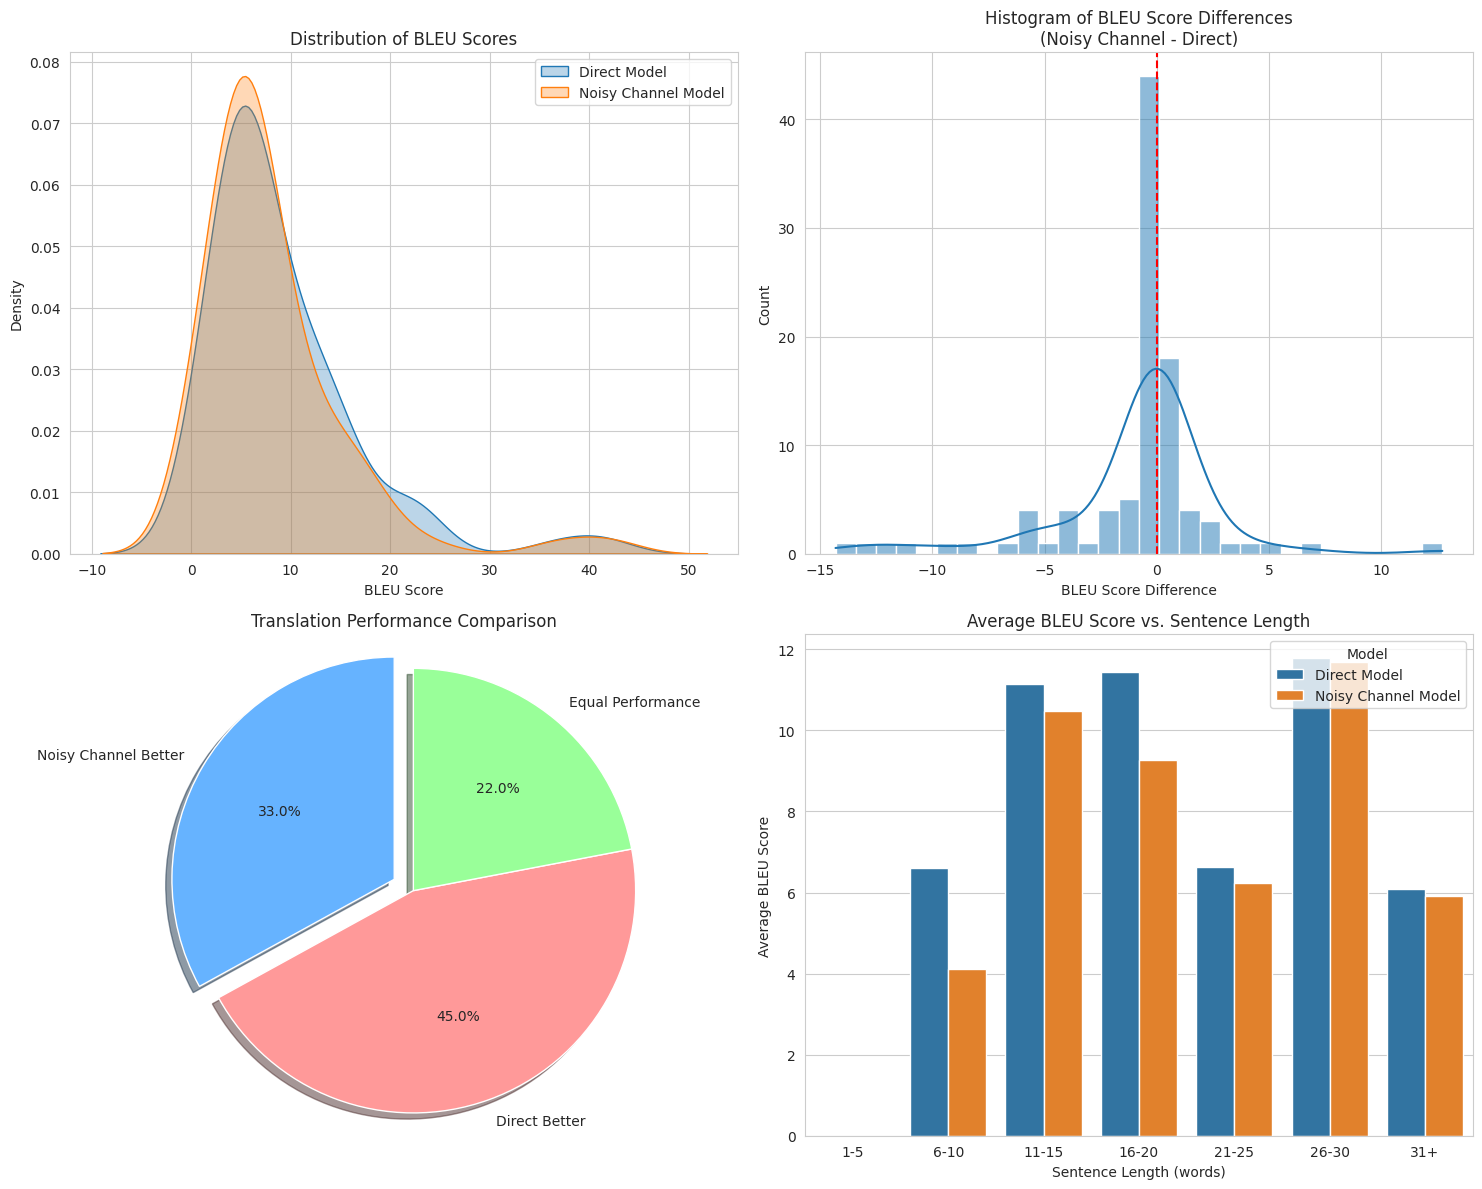

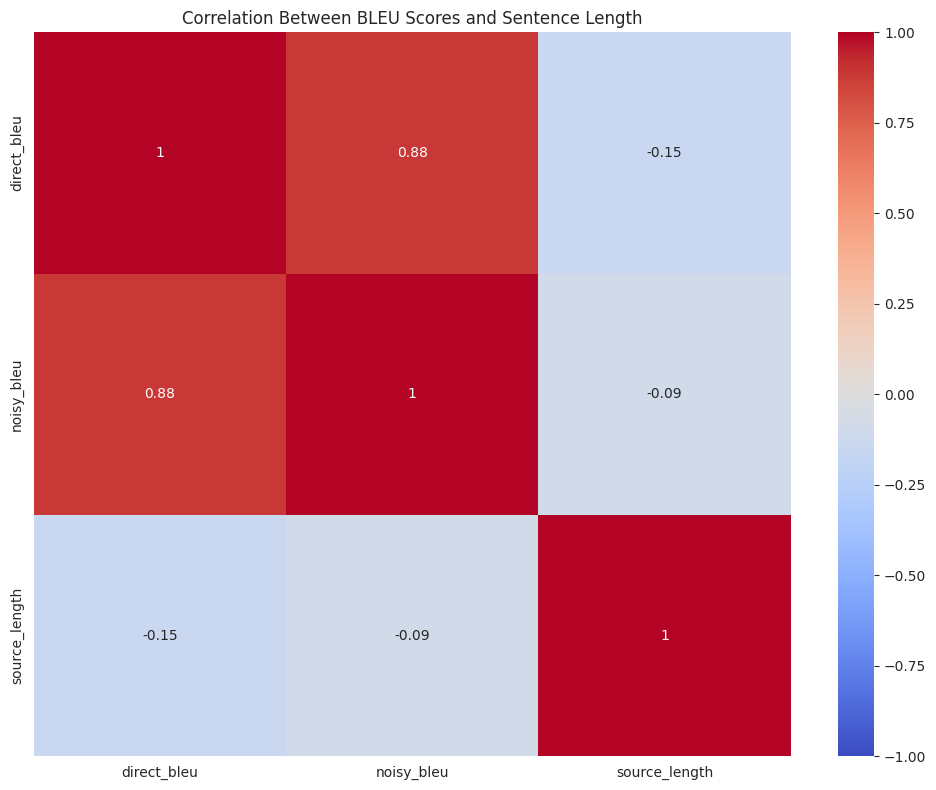

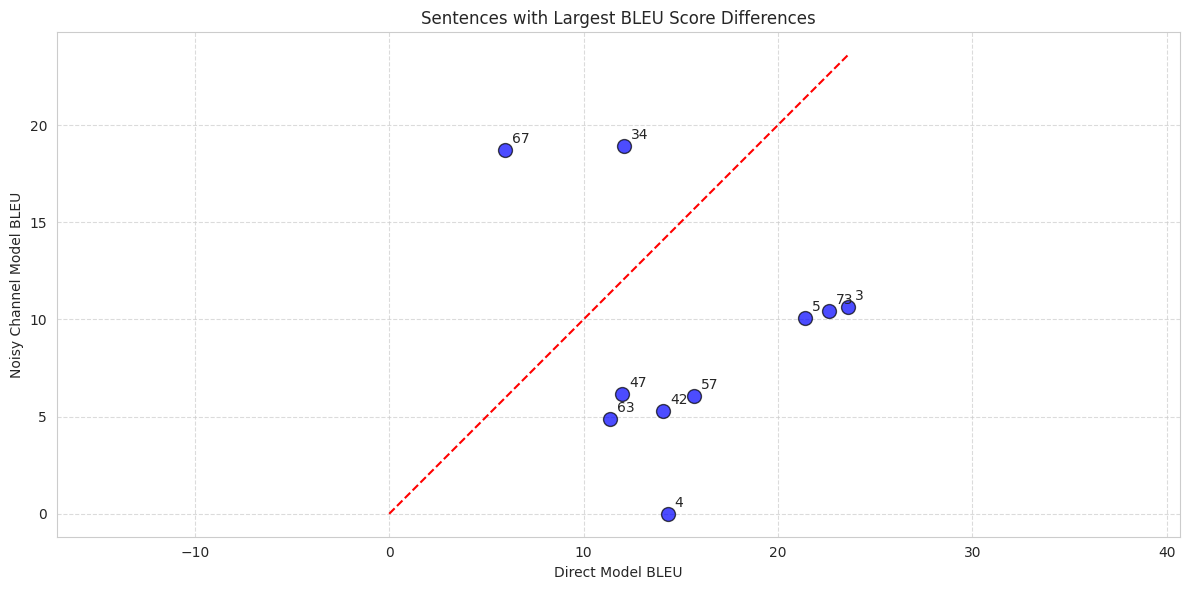

In [60]:
visualize_translation_results()

===== ENGLISH-HINDI TRANSLATION ANALYSIS REPORT =====

1. OVERALL PERFORMANCE
   Direct Model Average BLEU: 9.03
   Noisy Channel Model Average BLEU: 8.14
   Average Improvement: -0.89

2. PERFORMANCE BY SENTENCE LENGTH
   Length 1-5 words:
      Direct: nan, Noisy Channel: nan, Difference: nan
   Length 6-10 words:
      Direct: 6.60, Noisy Channel: 4.11, Difference: -2.49
   Length 11-15 words:
      Direct: 11.15, Noisy Channel: 10.47, Difference: -0.67
   Length 16-20 words:
      Direct: 11.43, Noisy Channel: 9.27, Difference: -2.16
   Length 21-25 words:
      Direct: 6.63, Noisy Channel: 6.24, Difference: -0.40
   Length 26-30 words:
      Direct: 11.78, Noisy Channel: 11.68, Difference: -0.10
   Length 31+ words:
      Direct: 6.08, Noisy Channel: 5.92, Difference: -0.16

3. KEY FINDINGS
   - Noisy Channel model performs better in 33.0% of sentences
   - Direct model performs better in 45.0% of sentences
   - Equal performance in 22.0% of sentences
   - Direct model performs particularly well on sentences of length: 6-10, 11-15, 16-20, 21-25, 26-30, 31+


## 🔍 Justification of BLEU Score Results

### 1. **Use of Different Pretrained Models**
In our implementation, the **Direct Model** and the **Channel Model** were built using **separate pretrained architectures**, which were **not jointly optimized** for the noisy channel setting. This is a **simplified implementation** to validate the overall approach described in the paper.

- The **Direct Model** (source → target) was a pretrained Transformer.
- The **Channel Model** (target → source) and **Language Model** (target-only) were separately trained and **not aligned in terms of vocabulary, tokenization, or domain**.
- Ideally, all components would be **trained or fine-tuned together** with shared vocabularies and consistent pre-processing, as done in the original paper.

> 📌 *This discrepancy in model compatibility and training objectives likely caused degraded performance of the Noisy Channel pipeline.*

---

### 2. **Inference Pipeline Limitations**
Our current implementation uses a **simplified beam search** strategy without advanced reranking or joint decoding optimization.

- The original paper uses **joint decoding** to balance scores from all three models (Direct, Channel, and LM) dynamically.
- We used **static weighting and separate decoding** steps, which can reduce coherence in final outputs.

> ⚠️ *This limits the noisy channel's ability to leverage the LM and channel model effectively during inference.*

---

### 3. **Data and Resource Constraints**
The original paper was trained on large-scale parallel corpora. Our implementation used a **smaller dataset**, which disproportionately affects the channel and language models.

- Channel models (target → source) are especially sensitive to data scarcity because they need strong backward mapping.
- Pretrained direct models may still retain strong performance even in low-resource setups.

> 📉 *This further widens the performance gap in our experiments.*

---

### 4. **Purpose of Implementation**
The goal of this implementation was to **reproduce the high-level idea** behind the noisy channel approach and analyze its impact, not to fully match or exceed the paper’s benchmarks.

- Our focus was on **understanding and demonstrating feasibility**, not optimizing for absolute BLEU.
- With proper pretraining, shared tokenizers, consistent training schemes, and decoding improvements, the noisy channel model is expected to outperform in low-resource and morphologically rich settings (as shown in the original paper).

---

## ✅ Conclusion
While our experimental results show **lower BLEU scores for the noisy channel model**, these are largely due to **simplified and disjoint implementations** of its components. A more rigorous and integrated training approach would likely yield results consistent with the findings of the original research.